In [26]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import glob, os, re
import herald_visualization.echem as ec
from herald_visualization.mpr2csv import cycle_mpr2csv, id_to_path, import_settings
from herald_visualization.plot import plot_cycle, plot_gitt, plot_multi_cell

In [27]:
plt_params = {# 'axes.labelsize': 'x-large',
#               'axes.titlesize': 'x-large',
#               'xtick.labelsize': 'x-large',
#               'ytick.labelsize': 'x-large',
              'font.family': 'serif',
              'axes.labelsize': 20,
              'axes.labelweight': 'bold',  # Make axes labels bold
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'xtick.major.size': 7,
              'ytick.major.size': 7,
              'xtick.major.width': 2.0,
              'ytick.major.width': 2.0,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'font.size': 24,
              'axes.linewidth': 2.0,
              'lines.dashed_pattern': (5, 2.5),
              'lines.markersize': 10,
              'lines.linewidth': 3,
              'lines.markeredgewidth': 1,
              'lines.markeredgecolor': 'k',
              'legend.fontsize': 16,  # Adjust the font size of the legend
              'legend.title_fontsize': 24,  # Increase legend title size if needed
              'legend.frameon': True
    }
plt.rcParams.update(plt_params)

In [28]:
os.getcwd()

'/Users/eschl/MIT Dropbox/Christopher Eschler/MIT/_Grad/Thesis/Data/herald_visualization/notebooks'

In [29]:
main_cells_df = pd.read_csv('../../PROPEL-1K/In-house cells and syntheses - Coin Cells.csv', index_col='Identifier')
cycling_mask = main_cells_df['Test Type'] == 'Cycling'
print(main_cells_df[cycling_mask])

             Date Made  Channel NB Entry Creator  \
Identifier                                         
052A        11/25/2024      NaN      NaN      CE   
053A        11/25/2024      NaN      NaN      CE   
053E         12/5/2024      NaN      NaN      CE   
053G         12/5/2024      NaN      NaN      CE   
054A         12/5/2024      NaN      NaN      CE   
054B         12/5/2024      NaN      NaN      CE   
055A         12/5/2024      NaN      NaN      CE   
056C        12/17/2024      NaN      NaN      CE   
056D        12/17/2024      NaN      NaN      CE   
056E          1/2/2025      NaN      NaN      RH   
056F          1/2/2025      NaN      NaN      RH   
057C        12/17/2024      NaN      NaN      CE   
057D        12/17/2024      NaN      NaN      CE   
057E         1/16/2025  4100-11      NaN      CE   
058A         1/13/2025      NaN      NaN      CE   
058B         1/13/2025      NaN      NaN      CE   
058C         1/16/2025   4100-2      NaN      CE   
059A        

In [18]:
def summarize_fom(path, afx='', bfx='', bfx_ratio=0):
    csv_files = glob.glob(os.path.join(path, '*.csv'))
    data_file = [file for file in csv_files if 'cycle_summary' not in file and 'PEIS' not in file][0]

    try:
        df = pd.read_csv(data_file)
        summary = pd.read_csv(os.path.join(path, 'cycle_summary.csv'))
    except:
        print("Issue encountered when reading files.")

    cha_mask = df['state'] == '0'
    dis_mask = df['state'] == '1'
    rest_mask = df['state'] == 'R'
    
    fom = {'afx': afx, 
           'bfx': bfx, 
           'bfx_ratio': bfx_ratio}
    fom['Specific discharge energy 0'] = summary.loc[0, 'Specific Discharge Energy Total AM']
    fom['Specific discharge energy 1'] = summary.loc[1, 'Specific Discharge Energy Total AM']
    fom['Max specific discharge energy'] = summary['Specific Discharge Energy Total AM'].max()
    fom['Discharge energy retention 0,1'] = summary.loc[1, 'Specific Discharge Energy Total AM']/summary.loc[0, 'Specific Discharge Energy Total AM']
    # fom['Average discharge energy retention 0,5'] = (summary.loc[5, 'Specific Discharge Energy Total AM']/summary.loc[0, 'Specific Discharge Energy Total AM'])**0.2
    fom['Specific discharge capacity 0'] = summary.loc[0, 'Specific Discharge Capacity Total AM']
    fom['Specific discharge capacity 1'] = summary.loc[1, 'Specific Discharge Capacity Total AM']
    fom['Max specific discharge capacity'] = summary['Specific Discharge Capacity Total AM'].max()
    fom['Discharge capacity retention 0,1'] = summary.loc[1, 'Specific Discharge Capacity Total AM']/summary.loc[0, 'Specific Discharge Capacity Total AM']
    # fom['Average discharge capacity retention 0,5'] = (summary.loc[5, 'Specific Discharge Capacity Total AM']/summary.loc[0, 'Specific Discharge Capacity Total AM'])**0.2
    fom['Discharge overpotential 0'] = df[(df['half cycle'] == 1) & rest_mask]['Voltage'].max() - df[(df['half cycle'] == 1) & dis_mask]['Voltage'].min()
    fom['Charge overpotential 1'] = df[(df['half cycle'] == 2) & cha_mask]['Voltage'].max() - df[(df['half cycle'] == 2) & rest_mask]['Voltage'].min()

    return fom


def add_to_fom_df(fom_df, cell_id, afx='', bfx='', bfx_ratio=0):
    fom = summarize_fom(os.path.join(id_to_path(cell_id), 'outputs'), afx=afx, bfx=bfx, bfx_ratio=bfx_ratio)
    fom_df.loc[cell_id] = fom
    return fom_df

In [30]:
# ids = ['CC053A', 'CC053B', 'CC053C', 'CC053E', 'CC053F', 'CC053G'] # Cat045
# ids = ['CC055A'] # Cat046
# ids = ['CC063A'] # Cat047
# ids = ['CC052A', 'CC052B', 'CC052C', 'CC052D'] # Cat043
# ids = ['CC054A', 'CC054B'] # Cat044
# ids = ['CC060A', 'CC060D'] # Cat053
# ids = ['CC061A', 'CC061C'] # Cat054
# ids = ['CC056A', 'CC056B', 'CC056C', 'CC056D', 'CC056E', 'CC056F'] # Cat049
# ids = ['CC057A', 'CC057B', 'CC057C', 'CC057D', 'CC057E'] # Cat050
# ids = ['CC064A', 'CC064B'] # Cat061
for id in ids:
    cycle_mpr2csv(os.path.join(id_to_path(id)))

NameError: name 'ids' is not defined

../../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/241217-CC056A-C50-1V-4p4V_CV-GITT_10SoC_6h/outputs
['../../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/241217-CC056A-C50-1V-4p4V_CV-GITT_10SoC_6h/outputs/cycle_summary.csv', '../../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/241217-CC056A-C50-1V-4p4V_CV-GITT_10SoC_6h/outputs/241217-CC056A-C50-1V-4p4V_CV-GITT_10SoC_6h.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/2714917034.py:7: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


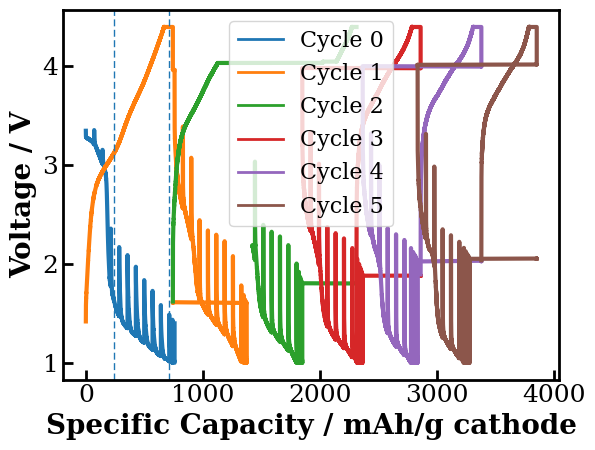

In [46]:
dir_name = os.path.join(id_to_path('CC056A'), 'outputs')
print(dir_name)
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)

ec.charge_discharge_plot(df, cycles=[0,1,2,3,4,5], norm='mass')
# plt.xlim(0, 800)
for x in [713/3, 713]:
    plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/241217-CC056A-C50-1V-4p4V_CV-GITT_10SoC_6h/outputs/241217-CC056A-C50-1V-4p4V_CV-GITT_10SoC_6h.csv', '../../../PROPEL-1K/Li-Fe0p75Mn0p25F3-25CB-C1-CCPP/241206-CC053F-C50-1V-4p4V_CV-GITT_10SoC_6h/outputs/241206-CC053F-C50-1V-4p4V_CV-GITT_10SoC_6h.csv', '../../../PROPEL-1K/Li-MnF3-25CB-C1-CCPP/241217-CC057A-C50-1V-4p4V_CV-GITT_10SoC_6h/outputs/241217-CC057A-C50-1V-4p4V_CV-GITT_10SoC_6h.csv']


/Users/eschl/Dropbox (MIT)/MIT/_Grad/Thesis/Data/herald_visualization/herald_visualization/plot.py:150: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(file))
/Users/eschl/Dropbox (MIT)/MIT/_Grad/Thesis/Data/herald_visualization/herald_visualization/plot.py:150: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(file))
/Users/eschl/Dropbox (MIT)/MIT/_Grad/Thesis/Data/herald_visualization/herald_visualization/plot.py:150: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(file))


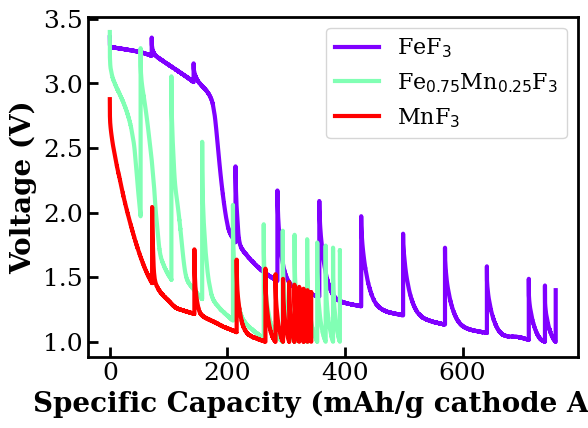

In [47]:
cell_ids = ['CC056A', 'CC053F', 'CC057A']
data_files = []
for id in cell_ids:
    path = os.path.join(id_to_path(id), 'outputs')
    data_file = glob.glob(path+'/*GITT*.csv')[0]
    data_files.append(data_file)
print(data_files)
plot_multi_cell(data_files, cycles=[[0],[0],[0]])
plt.legend(['FeF$_3$', 'Fe$_{0.75}$Mn$_{0.25}$F$_3$', 'MnF$_3$'])

['../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/250102-CC056E-C20-1V-4p4V_CV/outputs/250102-CC056E-C20-1V-4p4V.csv', '../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/250102-CC056E-C20-1V-4p4V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/1624137373.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.8040054


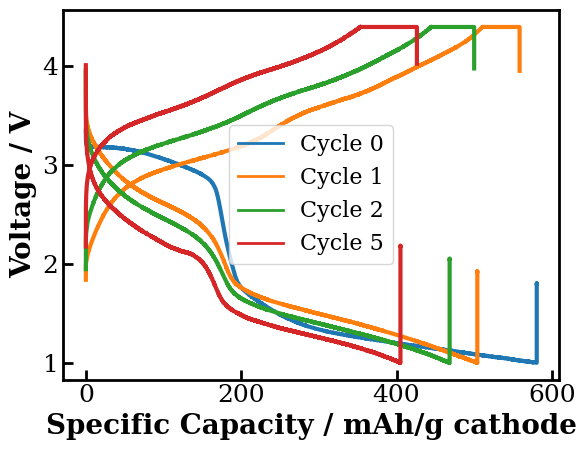

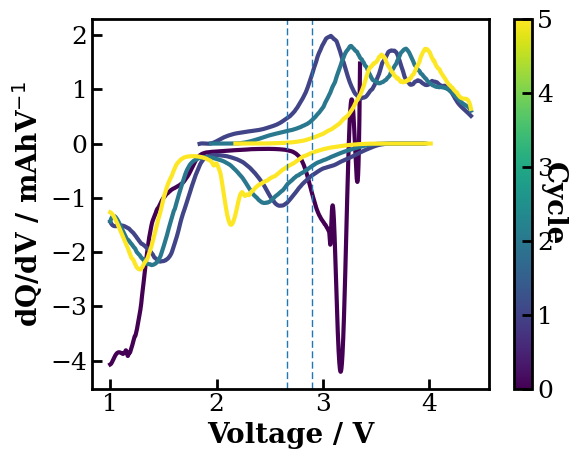

In [31]:
dir_name = os.path.join(id_to_path('CC056E'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV_Mn0 = df_no_ocv[df_no_ocv['Voltage'] < df_sum.loc[1, 'UCV'] - 0.01]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

cc056e_full_cap = df_sum['Specific Discharge Capacity Total AM']
cc056e_energy = df_sum['Specific Discharge Energy Total AM']

ec.charge_discharge_plot(df, cycles=[0,1,2,5], norm='mass')
ec.multi_dqdv_plot(df_no_CV_Mn0 , cycles=[0,1,2,5], polynomial_spline=1)
for x in [2.66, 2.90]:
    plt.axvline(x, linestyle='--', linewidth=1)


['../../PROPEL-1K/Li-Fe0p75Mn0p25F3-25CB-C1-CCPP/241206-CC053G-C20-1V-4p5V_CV/outputs/241206-CC053G-C20-1V-4p5V_CV.csv', '../../PROPEL-1K/Li-Fe0p75Mn0p25F3-25CB-C1-CCPP/241206-CC053G-C20-1V-4p5V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3535341155.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.41812364


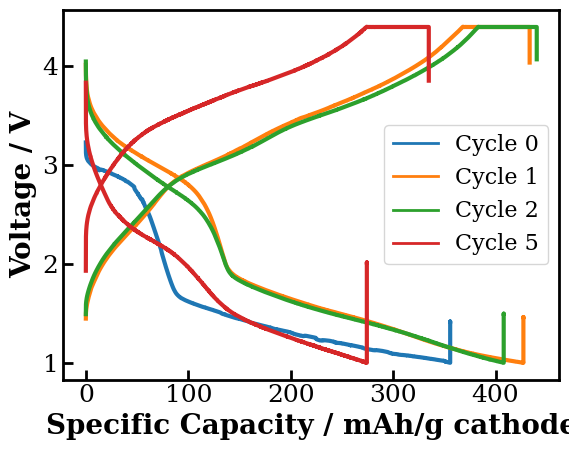

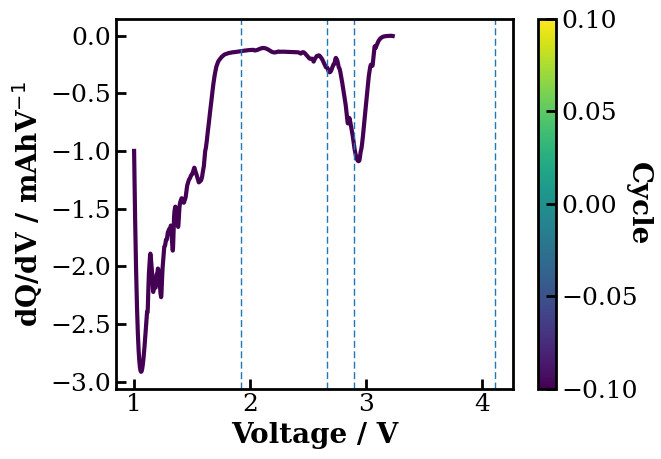

In [32]:
dir_name = os.path.join(id_to_path('CC053G'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV_Mn25 = df_no_ocv[df_no_ocv['Voltage'] < df_sum.loc[1, 'UCV'] - 0.01]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

cc053g_full_cap = df_sum['Specific Discharge Capacity Total AM']
cc053g_energy = df_sum['Specific Discharge Energy Total AM']

ec.charge_discharge_plot(df, cycles=[0,1,2,5], norm='mass')
ec.multi_dqdv_plot(df_no_CV_Mn25, cycles=[0], polynomial_spline=1)
for x in [1.92, 2.66, 2.90, 4.11]:
    plt.axvline(x, linestyle='--', linewidth=1)

['../../PROPEL-1K/Li-Fe0p56Mn0p44F3-25CB-C1-CCPP/241206-CC055A-C20-1V-4p4V_CV/outputs/241206-CC055A-C20-1V-4p4V_CV.csv', '../../PROPEL-1K/Li-Fe0p56Mn0p44F3-25CB-C1-CCPP/241206-CC055A-C20-1V-4p4V_CV/outputs/cycle_summary.csv', '../../PROPEL-1K/Li-Fe0p56Mn0p44F3-25CB-C1-CCPP/241206-CC055A-C20-1V-4p4V_CV/outputs/241206-CC055A-C20-1V-4p4V_CV_01_PEIS_C14.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3899425934.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.44473476


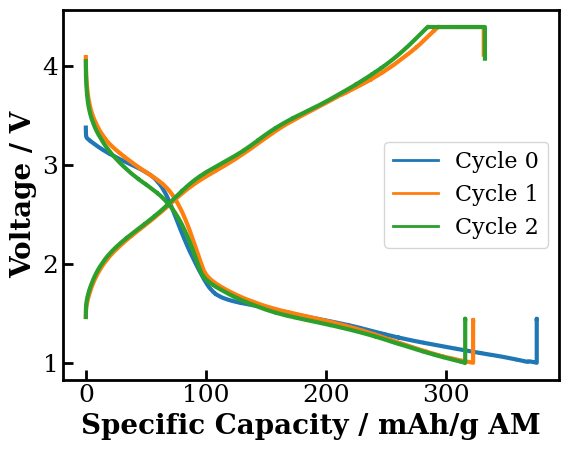

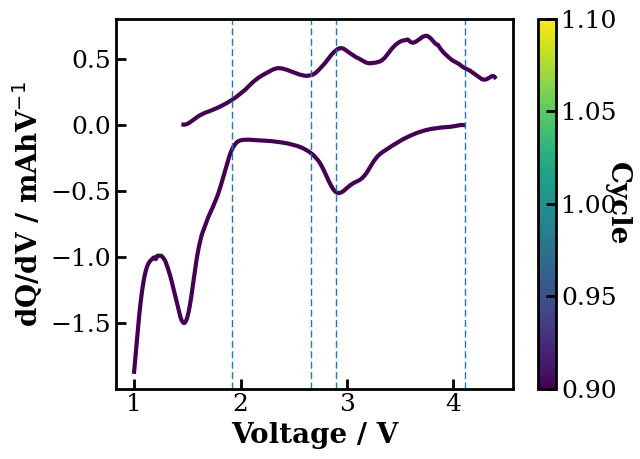

In [33]:
dir_name = os.path.join(id_to_path('CC055A'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV_Mn44 = df_no_ocv[df_no_ocv['Voltage'] < df_sum.loc[1, 'UCV'] - 0.01]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

cc055a_full_cap = df_sum['Specific Discharge Capacity Total AM']
cc055a_energy = df_sum['Specific Discharge Energy Total AM']

ec.charge_discharge_plot(df, cycles=[0,1,2], norm='full_mass')
ec.multi_dqdv_plot(df_no_CV_Mn44, cycles=[1], polynomial_spline=1)
for x in [1.92, 2.66, 2.90, 4.11]:
    plt.axvline(x, linestyle='--', linewidth=1)

['../../PROPEL-1K/Li-MnF3-25CB-C1-CCPP/241217-CC057C-C20-1V-4p4V_CV/outputs/241217-CC057C-C20-1V-4p4V_CV.csv', '../../PROPEL-1K/Li-MnF3-25CB-C1-CCPP/241217-CC057C-C20-1V-4p4V_CV/outputs/cycle_summary.csv']
0.6729305699999999


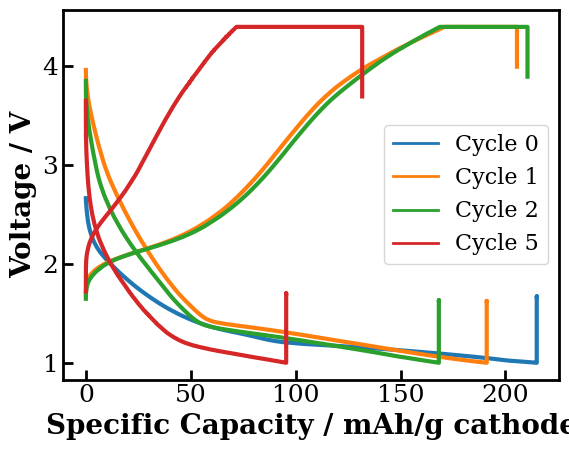

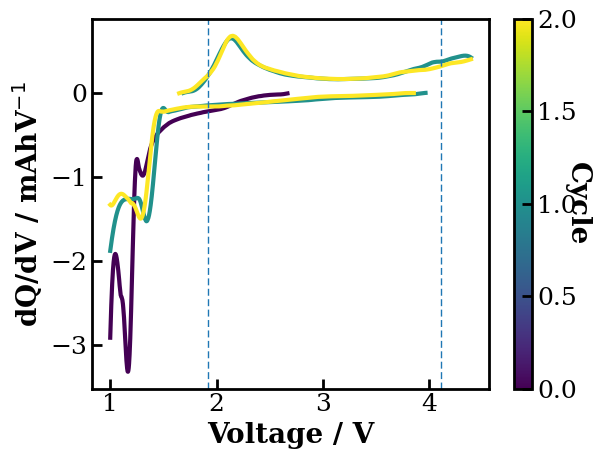

In [34]:
dir_name = os.path.join(id_to_path('CC057C'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV_Mn100 = df_no_ocv[df_no_ocv['Voltage'] < df_sum.loc[1, 'UCV'] - 0.01]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

cc057c_full_cap = df_sum['Specific Discharge Capacity Total AM']
cc057c_energy = df_sum['Specific Discharge Energy Total AM']

ec.charge_discharge_plot(df, cycles=[0,1,2,5], norm='mass')
ec.multi_dqdv_plot(df_no_CV_Mn100, cycles=[0,1,2], polynomial_spline=1)
for x in [1.92, 4.11]:
    plt.axvline(x, linestyle='--', linewidth=1)

['../../PROPEL-1K/Li-MnF3-25CB-C1-CCPP/250116-CC057E-C20-1V-4p8V_CV/outputs/250116-CC057E-C20-1V-4p8V_CV.csv', '../../PROPEL-1K/Li-MnF3-25CB-C1-CCPP/250116-CC057E-C20-1V-4p8V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/770685831.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.6695339599999999


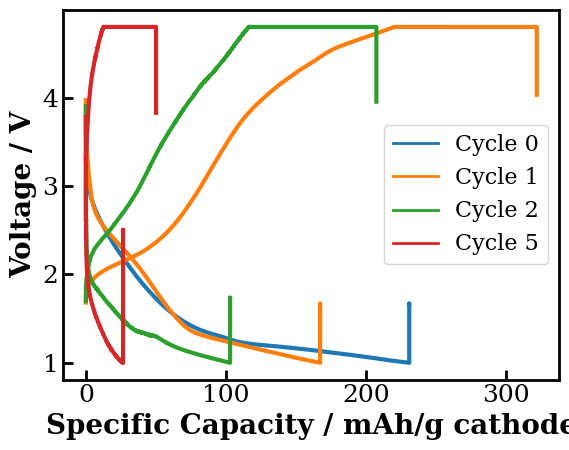

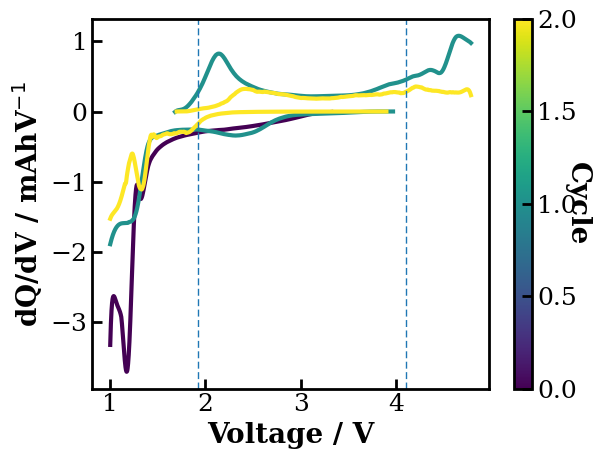

In [35]:
dir_name = os.path.join(id_to_path('CC057E'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV_Mn100_highV = df_no_ocv[df_no_ocv['Voltage'] < df_sum.loc[1, 'UCV'] - 0.01]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

cc057e_full_cap = df_sum['Specific Discharge Capacity Total AM']
cc057e_energy = df_sum['Specific Discharge Energy Total AM']

ec.charge_discharge_plot(df, cycles=[0,1,2,5], norm='mass')
ec.multi_dqdv_plot(df_no_CV_Mn100_highV, cycles=[0,1,2], polynomial_spline=1)
for x in [1.92, 4.11]:
    plt.axvline(x, linestyle='--', linewidth=1)

In [36]:
def multi_df_dqdv_plot(dfs, labels, cycle=1,
    colormap='tab10', 
    capacity_label='Capacity', 
    voltage_label='Voltage',
    polynomial_spline=3, s_spline=1e-5,
    polyorder_1 = 5, window_size_1=101,
    polyorder_2 = 5, window_size_2=1001,
    final_smooth=True):
    """
    Plot multiple dQ/dV cycles on the same plot with a colormap.
    Uses the internal dqdv_single_cycle function to calculate the dQ/dV curves.

    Parameters:
        df: DataFrame containing the data.
        cycles: List or array-like object of cycle numbers to plot.
        colormap: Name of the colormap to use (default: 'viridis').
        capacity_label: Label of the capacity column in the DataFrame (default: 'Capacity').
        voltage_label: Label of the voltage column in the DataFrame (default: 'Voltage').
        polynomial_spline (int, optional): Order of the spline interpolation for the capacity-voltage curve. Defaults to 3. Best results use odd numbers.
        s_spline (float, optional): Smoothing factor for the spline interpolation. Defaults to 1e-5.
        polyorder_1 (int, optional): Order of the polynomial for the first smoothing filter (Before spline fitting). Defaults to 5. Best results use odd numbers.
        window_size_1 (int, optional): Size of the window for the first smoothing filter. (Before spline fitting). Defaults to 101. Must be odd.
        polyorder_2 (int, optional): Order of the polynomial for the second optional smoothing filter. Defaults to 5. (After spline fitting and differentiation). Best results use odd numbers.
        window_size_2 (int, optional): Size of the window for the second optional smoothing filter. Defaults to 1001. (After spline fitting and differentiation). Must be odd.
        final_smooth (bool, optional): Whether to apply final smoothing to the dq/dv curve. Defaults to True.

    Returns:
        fig: The matplotlib figure object.
        ax: The matplotlib axes object.

    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import Normalize

    fig, ax = plt.subplots() 
    cm = plt.get_cmap(colormap)

    for i, df in enumerate(dfs):
        halfcycles = ec.halfcycles_from_cycle(df, cycle)
        for halfcycle in halfcycles:
            df_cycle = df[df['half cycle'] == halfcycle]
            voltage, dqdv, _ = ec.dqdv_single_cycle(df_cycle[capacity_label],
                                        df_cycle[voltage_label], 
                                        window_size_1=window_size_1,
                                        polyorder_1=polyorder_1,
                                        polynomial_spline=polynomial_spline,
                                        s_spline=s_spline,
                                        window_size_2=window_size_2,
                                        polyorder_2=polyorder_2,
                                        final_smooth=final_smooth)
            # Hackery to make only one instance of each df appear in the legend
            if halfcycle % 2 == 0:
                label = labels[i]
            else:
                label = '_'
            ax.plot(voltage, dqdv, color=cm(i), label=label)

    ax.set_xlabel('Voltage / V')
    y_labels = {'Capacity': 'dQ/dV / mAh/V', 'Specific Capacity': 'dQ/dV / mAh/g/V'}
    ax.set_ylabel(y_labels[capacity_label])
    ax.axhline(0, linewidth=2, color='k')
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return fig, ax

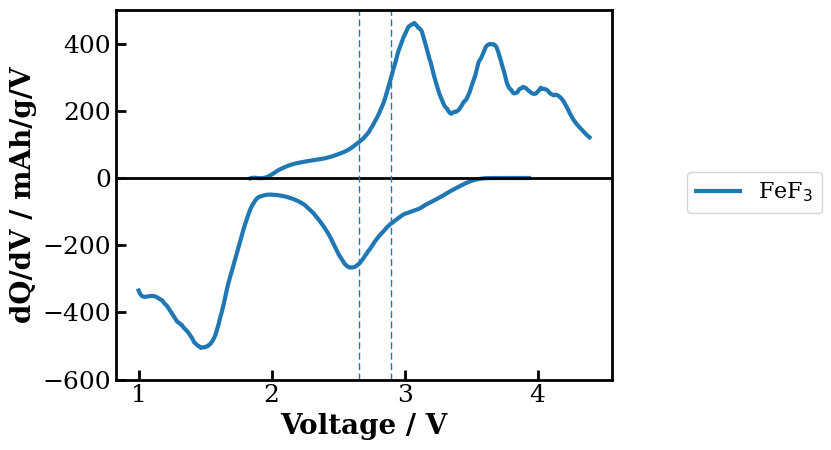

In [12]:
fig, ax = multi_df_dqdv_plot([df_no_CV_Mn0],
                             capacity_label='Specific Capacity', 
                             labels=['FeF$_3$'])
plt.ylim(-600, 500)
for x in [2.66, 2.90]:
    plt.axvline(x, linestyle='--', linewidth=1)

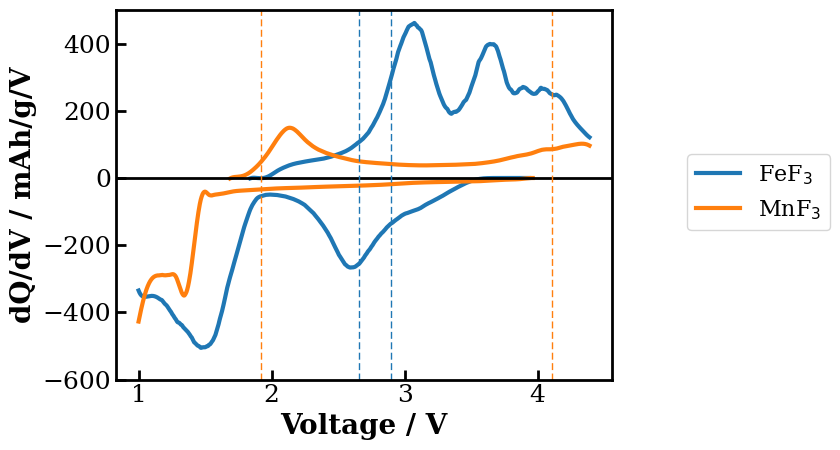

In [13]:
fig, ax = multi_df_dqdv_plot([df_no_CV_Mn0, df_no_CV_Mn100],
                             capacity_label='Specific Capacity', 
                             labels=['FeF$_3$', 'MnF$_3$'])
plt.ylim(-600, 500)
cm = plt.get_cmap('tab10')
for x in [2.66, 2.90]:
    plt.axvline(x, color=cm(0), linestyle='--', linewidth=1)
for x in [1.92, 4.11]:
    plt.axvline(x, color=cm(1), linestyle='--', linewidth=1)

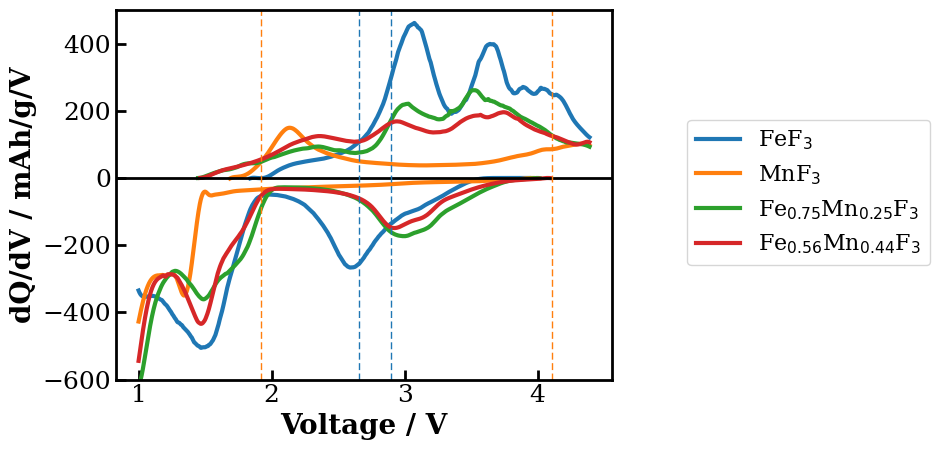

In [14]:
fig, ax = multi_df_dqdv_plot([df_no_CV_Mn0, df_no_CV_Mn100, df_no_CV_Mn25, df_no_CV_Mn44],
                             capacity_label='Specific Capacity', 
                             labels=['FeF$_3$', 'MnF$_3$', 'Fe$_{0.75}$Mn$_{0.25}$F$_3$', 'Fe$_{0.56}$Mn$_{0.44}$F$_3$'])
plt.ylim(-600, 500)
cm = plt.get_cmap('tab10')
for x in [2.66, 2.90]:
    plt.axvline(x, color=cm(0), linestyle='--', linewidth=1)
for x in [1.92, 4.11]:
    plt.axvline(x, color=cm(1), linestyle='--', linewidth=1)

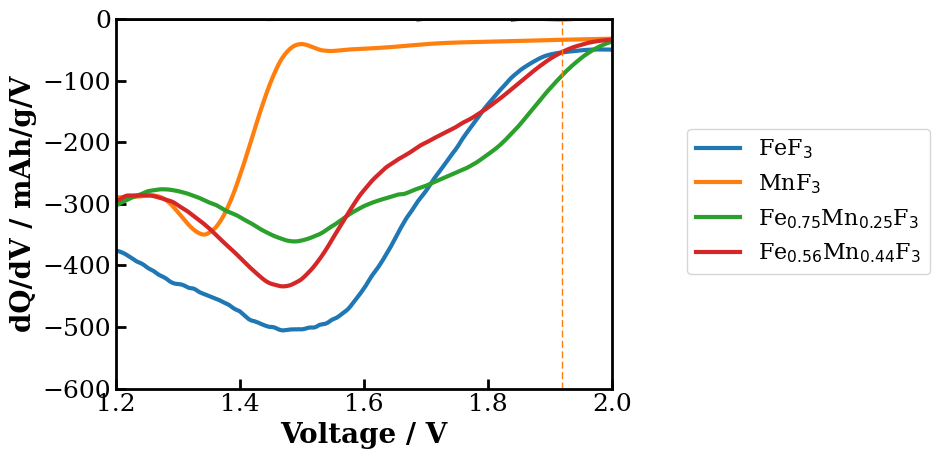

In [15]:
fig, ax = multi_df_dqdv_plot([df_no_CV_Mn0, df_no_CV_Mn100, df_no_CV_Mn25, df_no_CV_Mn44],
                             capacity_label='Specific Capacity', 
                             labels=['FeF$_3$', 'MnF$_3$', 'Fe$_{0.75}$Mn$_{0.25}$F$_3$', 'Fe$_{0.56}$Mn$_{0.44}$F$_3$'])
plt.ylim(-600, 0)
plt.xlim(1.2, 2)
cm = plt.get_cmap('tab10')
for x in [2.66, 2.90]:
    plt.axvline(x, color=cm(0), linestyle='--', linewidth=1)
for x in [1.92, 4.11]:
    plt.axvline(x, color=cm(1), linestyle='--', linewidth=1)

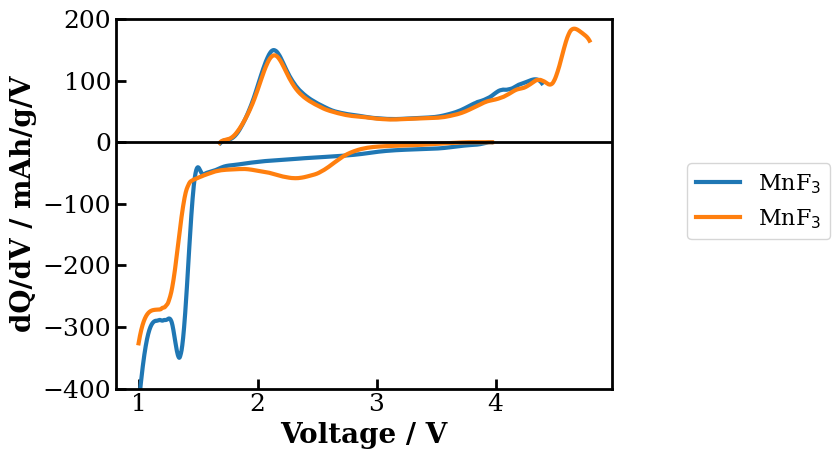

In [38]:
fig, ax = multi_df_dqdv_plot([df_no_CV_Mn100, df_no_CV_Mn100_highV],
                             cycle=1,
                             capacity_label='Specific Capacity', 
                             labels=['MnF$_3$', 'MnF$_3$'])
plt.ylim(-400, 200)
cm = plt.get_cmap('tab10')
# for x in [2.66, 2.90]:
#     plt.axvline(x, color=cm(0), linestyle='--', linewidth=1)
# for x in [1.92, 4.11]:
#     plt.axvline(x, color=cm(1), linestyle='--', linewidth=1)

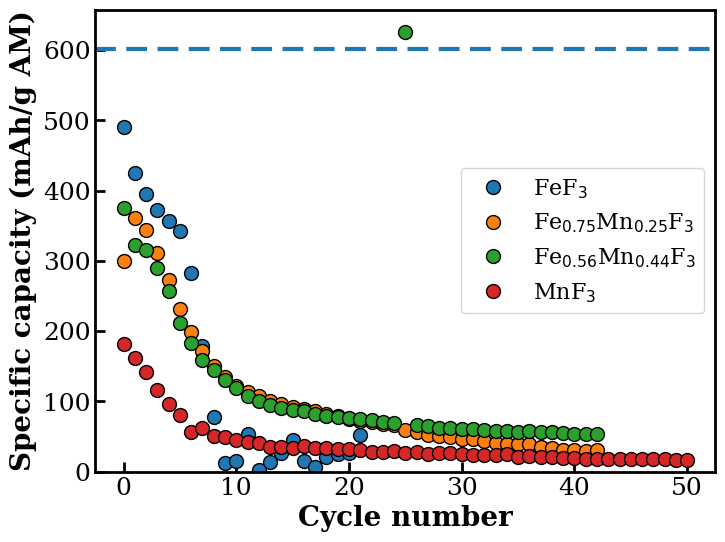

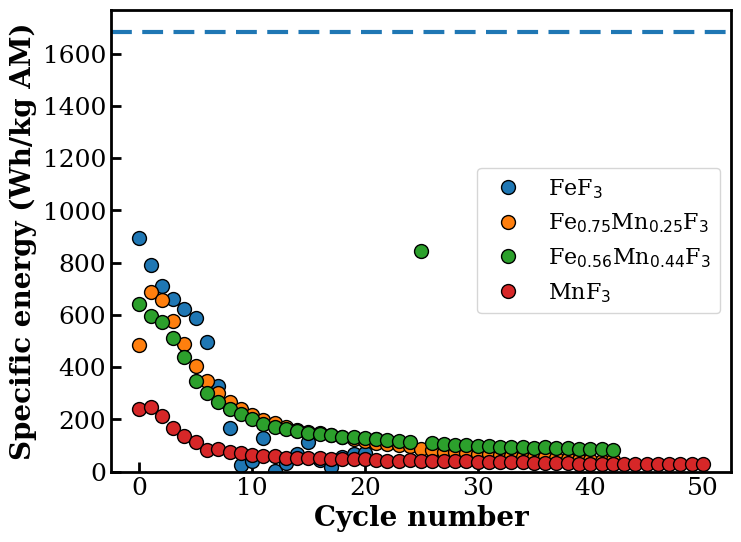

In [109]:
plt.figure(figsize=[8,6])
plt.plot(cc056e_full_cap, 'o', label='FeF$_3$')
plt.plot(cc053g_full_cap, 'o', label='Fe$_{0.75}$Mn$_{0.25}$F$_3$')
plt.plot(cc055a_full_cap, 'o', label='Fe$_{0.56}$Mn$_{0.44}$F$_3$')
plt.plot(cc057c_full_cap, 'o', label='MnF$_3$')
plt.axhline(601.5, linestyle='--')
plt.xlabel('Cycle number')
plt.ylabel('Specific capacity (mAh/g AM)')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.figure(figsize=[8,6])
plt.plot(cc056e_energy, 'o', label='FeF$_3$')
plt.plot(cc053g_energy, 'o', label='Fe$_{0.75}$Mn$_{0.25}$F$_3$')
plt.plot(cc055a_energy, 'o', label='Fe$_{0.56}$Mn$_{0.44}$F$_3$')
plt.plot(cc057c_energy, 'o', label='MnF$_3$')
plt.axhline(1684, linestyle='--')
plt.xlabel('Cycle number')
plt.ylabel('Specific energy (Wh/kg AM)')
plt.ylim(bottom=0)
plt.legend()
plt.show()

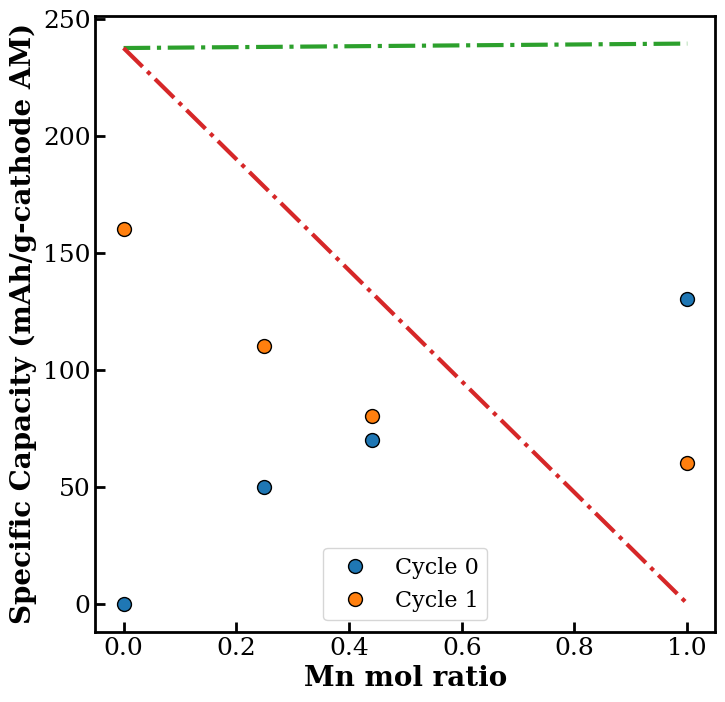

In [17]:
# Comparison of upper plateau specific capacities
# as a function of Mn content in Fe-Mn ternaries

# x = % Mn, y = spec. cap. of upper plateau
mn_pct = [0,0.25,0.44,1]
cyc0_upper_cap = [0,50,70,130]
cyc1_upper_cap = [160,110,80,60]

plt.figure(figsize=[8,8])
plt.plot(mn_pct, cyc0_upper_cap, 'o', label='Cycle 0')
plt.plot(mn_pct, cyc1_upper_cap, 'o', label='Cycle 1')
plt.plot([0,1],[237.5,239.4], '-.')
plt.plot([0,1],[237.5,0], '-.')
plt.xlabel('Mn mol ratio')
plt.ylabel('Specific Capacity (mAh/g-cathode AM)')
plt.legend()

['../../../PROPEL-1K/Li-Fe0p08Co0p92F3-25CB-C1-CCPP/241206-CC054A-C20-1V-4p4V_CV/outputs/241206-CC054A-C20-1V-4p4V_CV.csv', '../../../PROPEL-1K/Li-Fe0p08Co0p92F3-25CB-C1-CCPP/241206-CC054A-C20-1V-4p4V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/1136705008.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


1.03892915


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

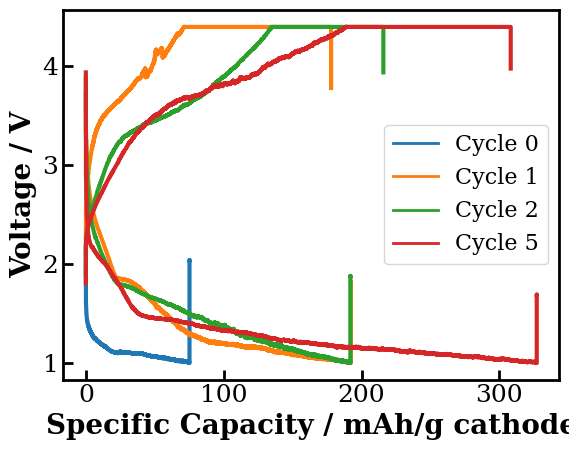

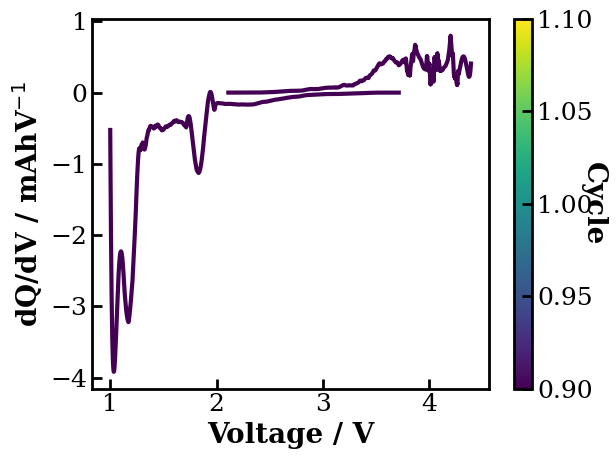

In [85]:
dir_name = os.path.join(id_to_path('CC054A'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV_Fe8Co92 = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

cc054a_full_cap = df_sum['Specific Discharge Capacity']
cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,5], norm='mass')
ec.multi_dqdv_plot(df_no_CV_Fe8Co92, cycles=[1], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

In [19]:
cells_df = pd.DataFrame(columns=['ids', 'afx', 'bfx', 'bfx_ratio'])
cells_df.loc['Cat045'] = {'ids': ['CC053A', 'CC053B', 'CC053C', 'CC053E', 'CC053F'], 'afx': 'FeF3', 'bfx': 'MnF3', 'bfx_ratio': 0.25} # Cat045
cells_df.loc['Cat046'] = {'ids': ['CC055A'], 'afx': 'FeF3', 'bfx': 'MnF3', 'bfx_ratio': 0.44} # Cat046
cells_df.loc['Cat047'] = {'ids': ['CC063A'], 'afx': 'FeF3', 'bfx': 'MnF3', 'bfx_ratio': 0.1} # Cat047
cells_df.loc['Cat043'] = {'ids': ['CC052A', 'CC052B', 'CC052C', 'CC052D'], 'afx': 'FeF3', 'bfx': 'CoF3', 'bfx_ratio': 0.19} # Cat043
cells_df.loc['Cat044'] = {'ids': ['CC054A', 'CC054B'], 'afx': 'FeF3', 'bfx': 'CoF3', 'bfx_ratio': 0.92} # Cat044
cells_df.loc['Cat053'] = {'ids': ['CC060A', 'CC060D'], 'afx': 'FeF3', 'bfx': 'CrF3', 'bfx_ratio': 0.1} # Cat053
cells_df.loc['Cat054'] = {'ids': ['CC061A', 'CC061C'], 'afx': 'FeF3', 'bfx': 'CrF3', 'bfx_ratio': 0.3} # Cat054
cells_df.loc['Cat049'] = {'ids': ['CC056A', 'CC056B', 'CC056C', 'CC056D', 'CC056E', 'CC056F'], 'afx': 'FeF3', 'bfx': '', 'bfx_ratio': 0} # Cat049
cells_df.loc['Cat050'] = {'ids': ['CC057A', 'CC057B', 'CC057C', 'CC057D', 'CC057E'], 'afx': 'FeF3', 'bfx': 'MnF3', 'bfx_ratio': 1} # Cat050

fom_df = pd.DataFrame(columns=['afx', 
                               'bfx', 
                               'bfx_ratio', 
                               'Specific discharge energy 0', 
                               'Specific discharge energy 1', 
                               'Max specific discharge energy', 
                               'Discharge energy retention 0,1', 
                               # 'Average discharge energy retention 0,5',
                               'Specific discharge capacity 0',
                               'Specific discharge capacity 1',
                               'Max specific discharge capacity',
                               'Discharge capacity retention 0,1',
                               # 'Average discharge capacity retention 0,5',
                               'Discharge overpotential 0',
                               'Charge overpotential 1'
                               ])
for index, row in cells_df.iterrows():
    for id in row['ids']:
        add_to_fom_df(fom_df, id, afx=row['afx'], bfx=row['bfx'], bfx_ratio=row['bfx_ratio'])

/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3038187899.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3038187899.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3038187899.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3038187899.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_67772/3038187899.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option 

In [39]:
print(fom_df)

         afx   bfx  bfx_ratio  Specific discharge energy 0  \
CC053A  FeF3  MnF3       0.25                   136.756891   
CC053B  FeF3  MnF3       0.25                    51.186835   
CC053C  FeF3  MnF3       0.25                   133.423515   
CC053E  FeF3  MnF3       0.25                   382.413821   
CC053F  FeF3  MnF3       0.25                   -36.788073   
CC055A  FeF3  MnF3       0.44                   643.237288   
CC063A  FeF3  MnF3       0.10                   826.204043   
CC052A  FeF3  CoF3       0.19                   136.505526   
CC052B  FeF3  CoF3       0.19                   868.314136   
CC052C  FeF3  CoF3       0.19                    -2.856014   
CC052D  FeF3  CoF3       0.19                   -13.258750   
CC054A  FeF3  CoF3       0.92                    70.632500   
CC054B  FeF3  CoF3       0.92                   668.050612   
CC060A  FeF3  CrF3       0.10                   879.940824   
CC060D  FeF3  CrF3       0.10                   754.294897   
CC061A  

In [42]:
print(fom_df.loc['CC061C'])

afx                                       FeF3
bfx                                       CrF3
bfx_ratio                                  0.3
Specific discharge energy 0         812.702729
Specific discharge energy 1         356.241745
Max specific discharge energy       812.702729
Discharge energy retention 0,1        0.438342
Specific discharge capacity 0       484.819521
Specific discharge capacity 1       190.475837
Max specific discharge capacity     484.819521
Discharge capacity retention 0,1       0.39288
Discharge overpotential 0             0.900818
Charge overpotential 1                0.631583
Name: CC061C, dtype: object


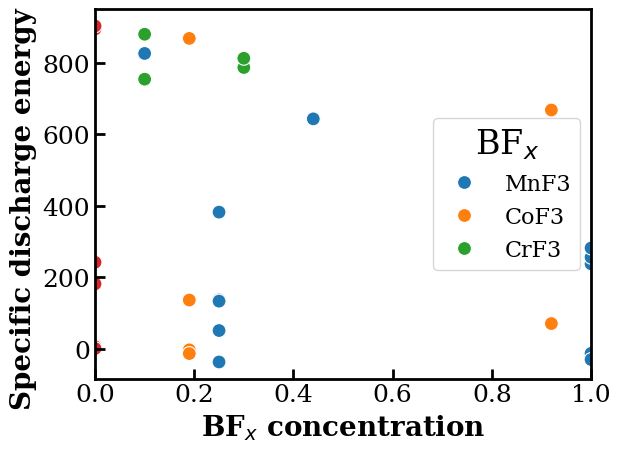

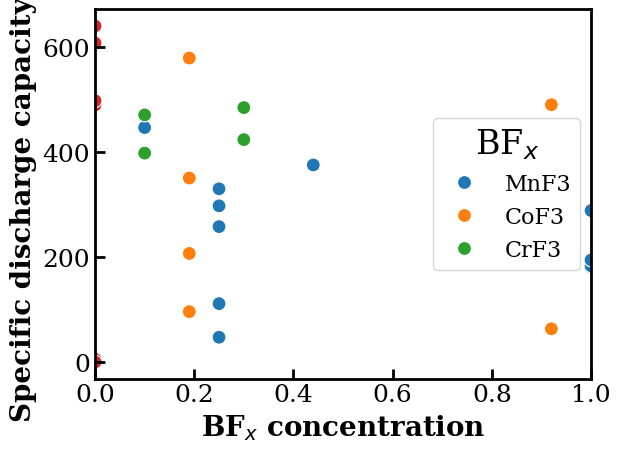

In [43]:
sn.scatterplot(data=fom_df, x='bfx_ratio', y='Specific discharge energy 0', hue='bfx')
plt.legend(title='BF$_x$')
plt.xlim(0,1)
plt.xlabel('BF$_x$ concentration')
plt.show()

sn.scatterplot(data=fom_df, x='bfx_ratio', y='Specific discharge capacity 0', hue='bfx')
plt.legend(title='BF$_x$')
plt.xlim(0,1)
plt.xlabel('BF$_x$ concentration')
plt.show()

['../../../PROPEL-1K/Li-Fe0p81Co0p19F3-25CB-C1-CCPP/241126-CC052B-C50-1V-4p5V_CV-GITT_10SoC_6h/outputs/241126-CC052B-C50-1V-4p5V_CV-GITT_10SoC_6h.csv', '../../../PROPEL-1K/Li-Fe0p81Co0p19F3-25CB-C1-CCPP/241126-CC052B-C50-1V-4p5V_CV-GITT_10SoC_6h/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/3172772513.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


1.7453215999999998


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Specific Capacity / mAh/g cathode', ylabel='Voltage / V'>)

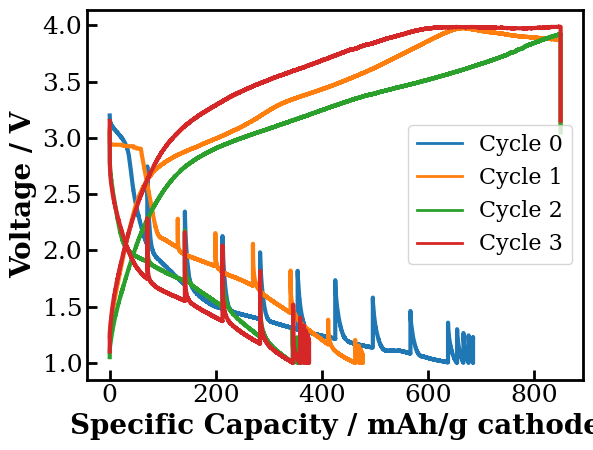

In [86]:
dir_name = os.path.join(id_to_path('CC052B'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
# ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p9Cr0p1F3-25CB-C1-CCPP/250116-CC060A-C20-1V-4p5V_CV/outputs/250116-CC060A-C20-1V-4p5V_CV.csv', '../../../PROPEL-1K/Li-Fe0p9Cr0p1F3-25CB-C1-CCPP/250116-CC060A-C20-1V-4p5V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/2671106077.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


1.03044476


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

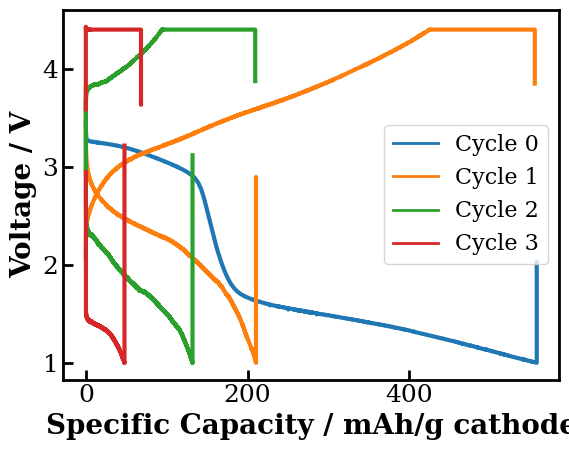

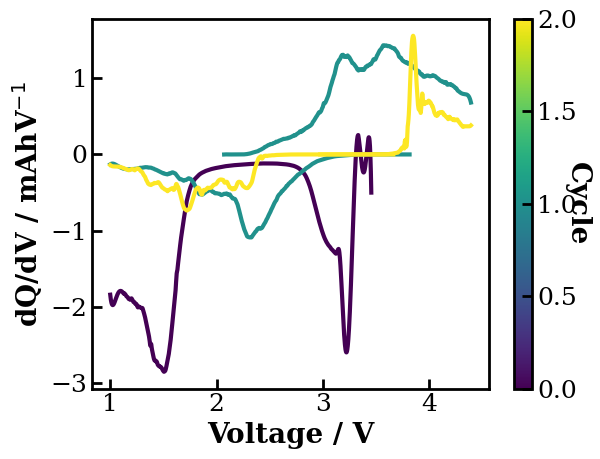

In [87]:
dir_name = os.path.join(id_to_path('CC060A'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p7Cr0p3F3-25CB-C1-CCPP/250116-CC061A-C20-1V-4p5V_CV/outputs/250116-CC061A-C20-1V-4p5V_CV.csv', '../../../PROPEL-1K/Li-Fe0p7Cr0p3F3-25CB-C1-CCPP/250116-CC061A-C20-1V-4p5V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/3957006156.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


1.0869840000000002


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

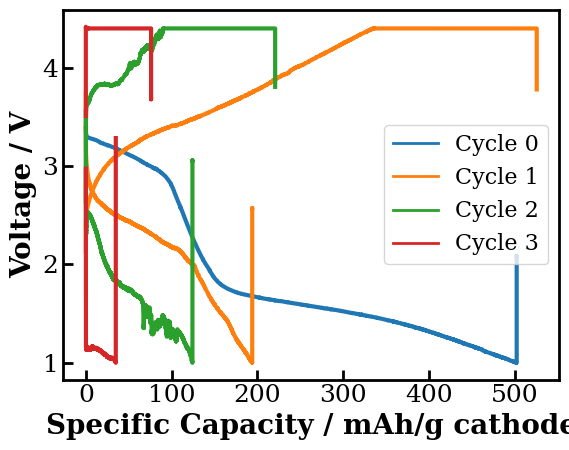

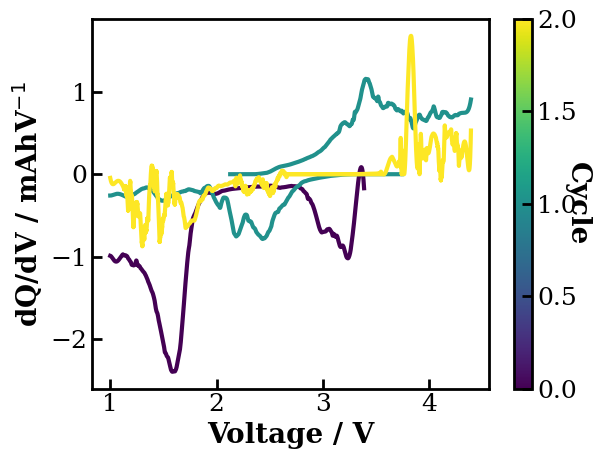

In [102]:
dir_name = os.path.join(id_to_path('CC061A'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p7Cr0p3F3-25CB-C1-CCPP/250116-CC061C-C20-1V-4p5V_CV/outputs/250116-CC061C-C20-1V-4p5V_CV.csv', '../../../PROPEL-1K/Li-Fe0p7Cr0p3F3-25CB-C1-CCPP/250116-CC061C-C20-1V-4p5V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/483082154.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.90081783


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

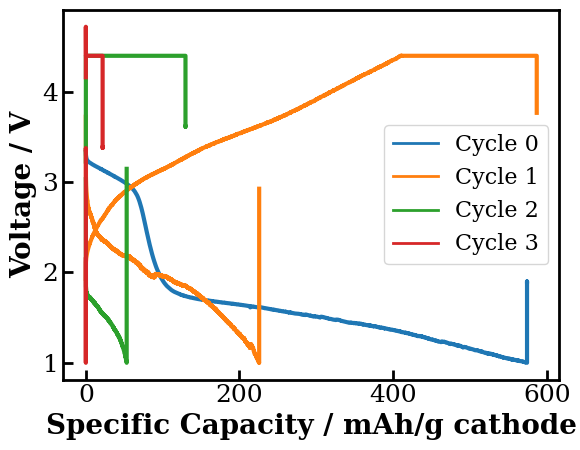

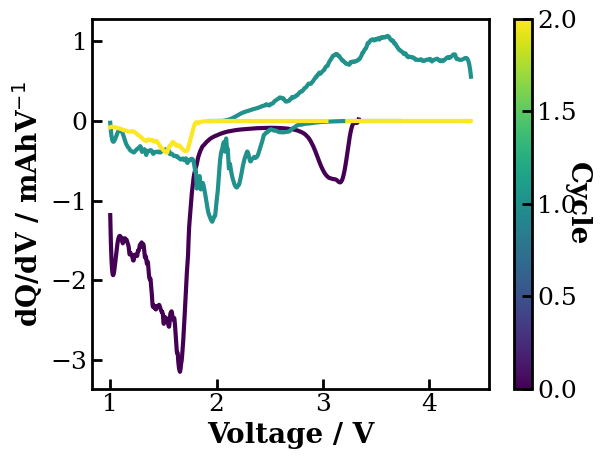

In [103]:
dir_name = os.path.join(id_to_path('CC061C'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/250102-CC056E-C20-1V-4p4V_CV/outputs/250102-CC056E-C20-1V-4p4V.csv', '../../../PROPEL-1K/Li-FeF3-25CB-C1-CCPP/250102-CC056E-C20-1V-4p4V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/2476490054.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.8040054


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

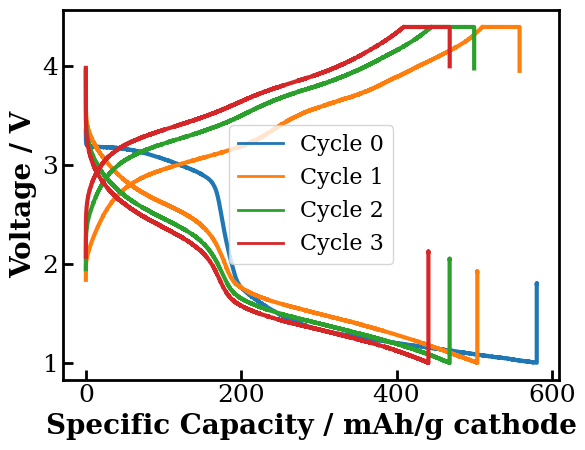

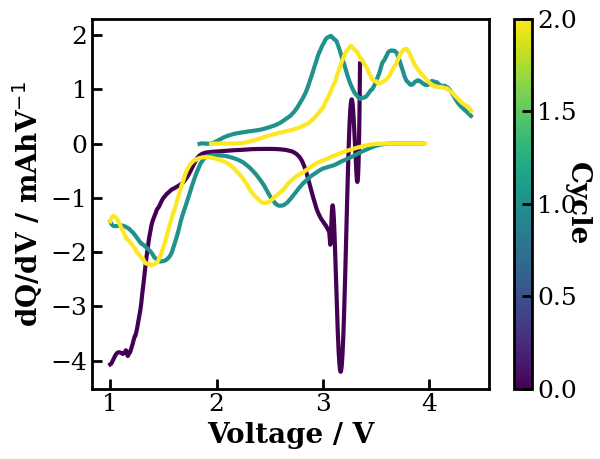

In [95]:
dir_name = os.path.join(id_to_path('CC056E'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p9Cr0p1F3-25CB-C1-CCPP/250116-CC060D-C20-1V-4p5V_CV/outputs/cycle_summary.csv', '../../../PROPEL-1K/Li-Fe0p9Cr0p1F3-25CB-C1-CCPP/250116-CC060D-C20-1V-4p5V_CV/outputs/250116-CC060D-C20-1V-4p5V_CV.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/2760284834.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


1.1054329999999999


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

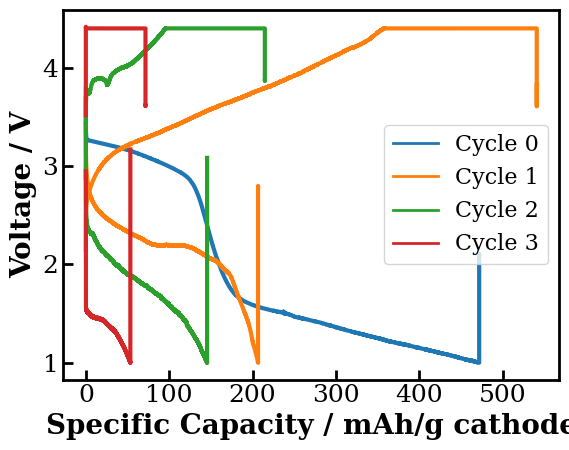

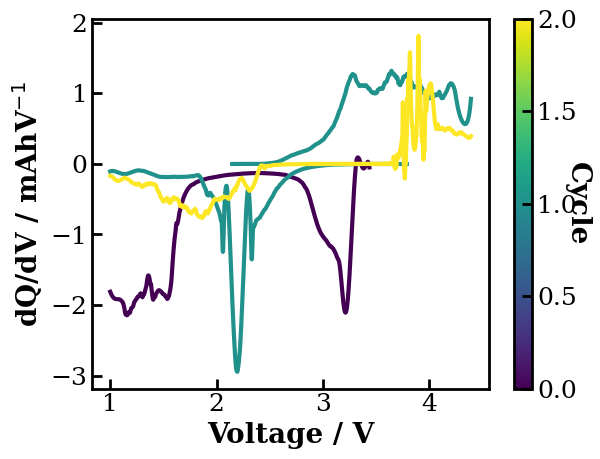

In [88]:
dir_name = os.path.join(id_to_path('CC060D'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p9Mn0p1F3-25CB-C1-CCPP-100HrBM/250116-CC063A-C20-1V-4p5V_CV/outputs/250116-CC063A-C20-1V-4p5V_CV.csv', '../../../PROPEL-1K/Li-Fe0p9Mn0p1F3-25CB-C1-CCPP-100HrBM/250116-CC063A-C20-1V-4p5V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/2636213471.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.7711338000000001


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Voltage / V', ylabel='dQ/dV / mAhV$^{-1}$'>)

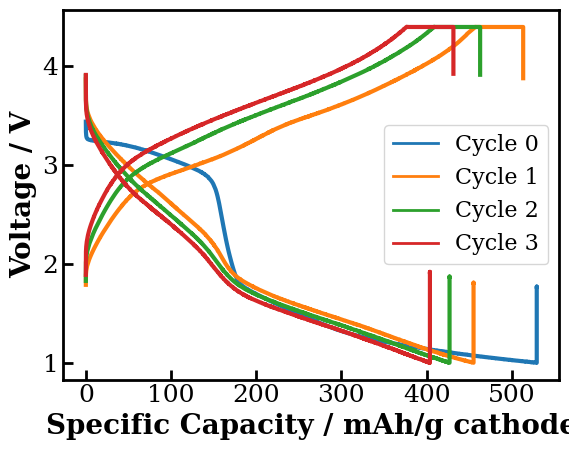

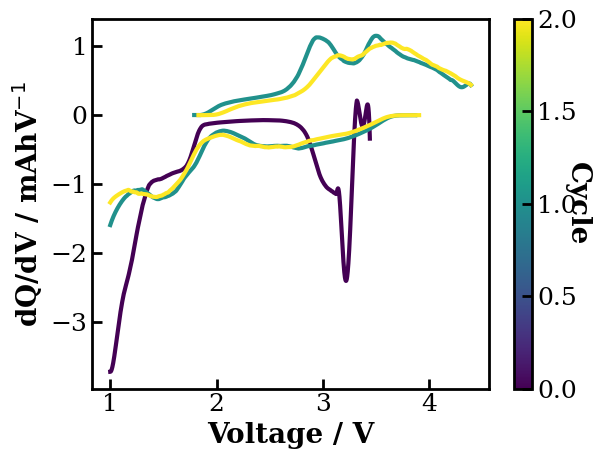

In [89]:
dir_name = os.path.join(id_to_path('CC063A'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p08Co0p92F3-25CB-C1-CCPP/241212-CC054B-C20-1V-4p4V_CV/outputs/241212-CC054B-C20-1V-4p4V_CV.csv', '../../../PROPEL-1K/Li-Fe0p08Co0p92F3-25CB-C1-CCPP/241212-CC054B-C20-1V-4p4V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/4131140363.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.5844187


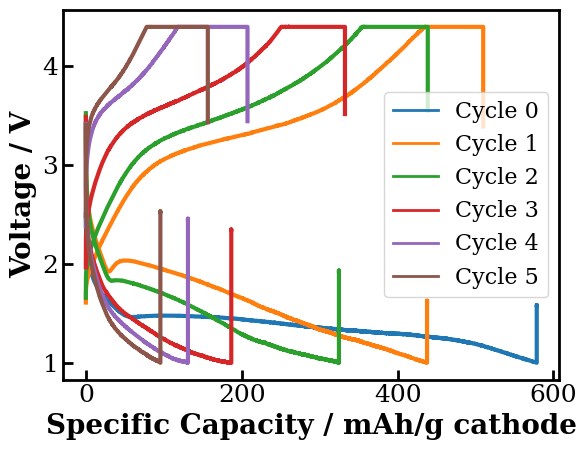

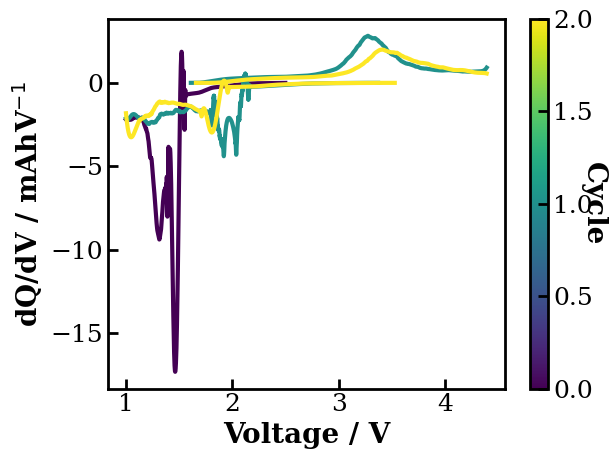

In [91]:
dir_name = os.path.join(id_to_path('CC054B'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3,4,5], norm='mass')
ax = ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# ax[1].set_ylim(-2,2)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-Fe0p81Co0p19F3-25CB-C1-CCPP/241126-CC052B-C50-1V-4p5V_CV-GITT_10SoC_6h/outputs/241126-CC052B-C50-1V-4p5V_CV-GITT_10SoC_6h.csv', '../../../PROPEL-1K/Li-Fe0p81Co0p19F3-25CB-C1-CCPP/241126-CC052B-C50-1V-4p5V_CV-GITT_10SoC_6h/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/910737666.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


1.7453215999999998


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Specific Capacity / mAh/g cathode', ylabel='Voltage / V'>)

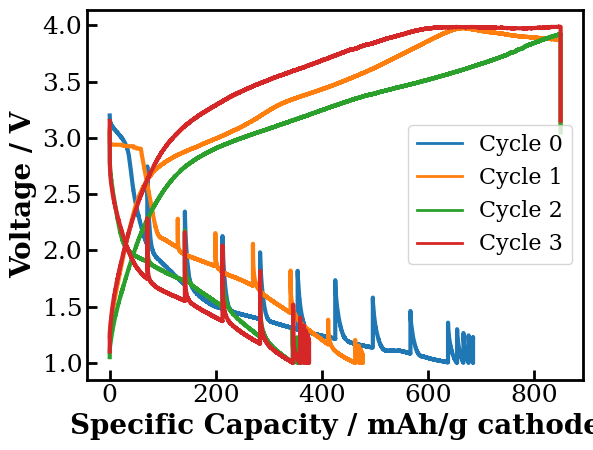

In [92]:
dir_name = os.path.join(id_to_path('CC052B'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 4.39]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

# cc054a_full_cap = df_sum['Specific Discharge Capacity']
# cc054a_energy = df_sum['Specific Discharge Energy']

ec.charge_discharge_plot(df, cycles=[0,1,2,3], norm='mass')
# ax = ec.multi_dqdv_plot(df_no_CV, cycles=[0,1,2], polynomial_spline=1)
# ax[1].set_ylim(-2,2)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-FeS2_FeS_S-25CB-GS1-CCPP/250125-CC064A-1p75C-1p2V-3V_CV/outputs/Li-FeS2-FeS-S.csv', '../../../PROPEL-1K/Li-FeS2_FeS_S-25CB-GS1-CCPP/250125-CC064A-1p75C-1p2V-3V_CV/outputs/cycle_summary.csv']
0.9287044000000002


(-13.198498589281598, 2.0)

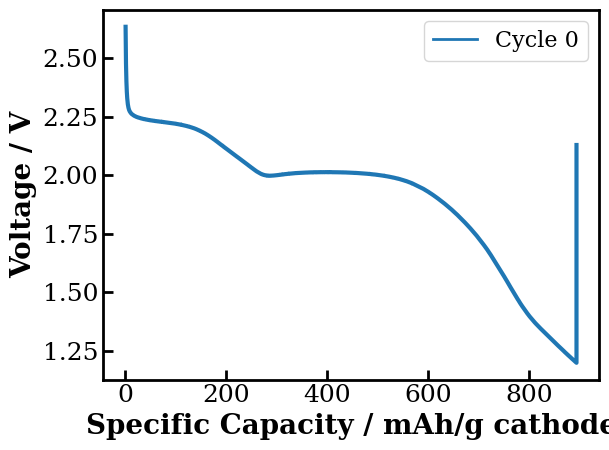

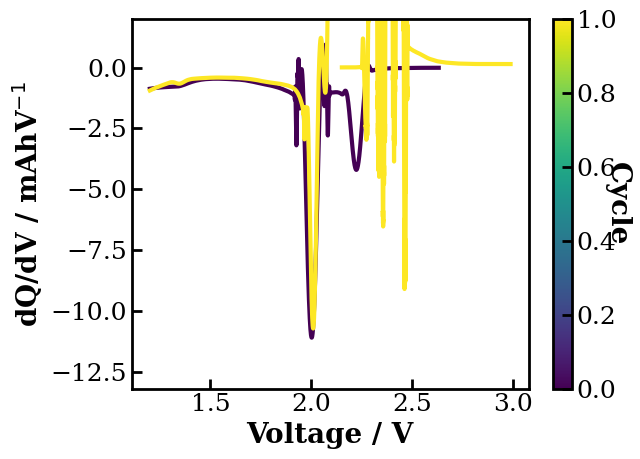

In [93]:
dir_name = os.path.join(id_to_path('CC064A'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file and 'PEIS' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 2.99]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

ec.charge_discharge_plot(df, cycles=[0], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1], polynomial_spline=1)
plt.ylim(top=2)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

['../../../PROPEL-1K/Li-FeS2_FeS_S-25CB-GS1-CCPP/250126-CC064B-0p1C-1p2V-3V_CV/outputs/250126-CC064B-0p1C-1p2V-3V_CV.csv', '../../../PROPEL-1K/Li-FeS2_FeS_S-25CB-GS1-CCPP/250126-CC064B-0p1C-1p2V-3V_CV/outputs/cycle_summary.csv']


/var/folders/45/z117g70n3_l3xzhnh36v3tqm0000gn/T/ipykernel_54318/1180644119.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


0.2743394000000001


(-19.092009775665723, 2.0)

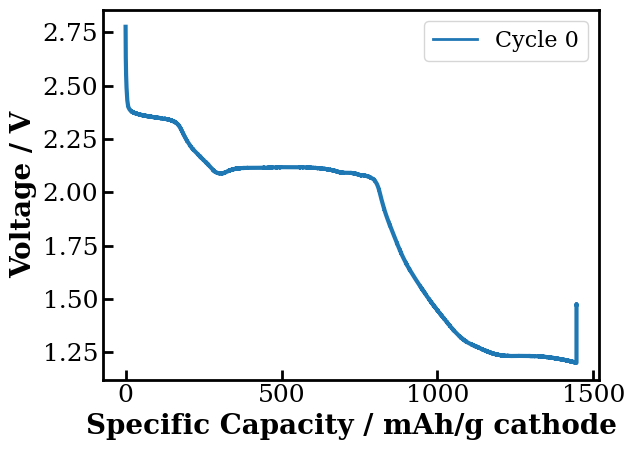

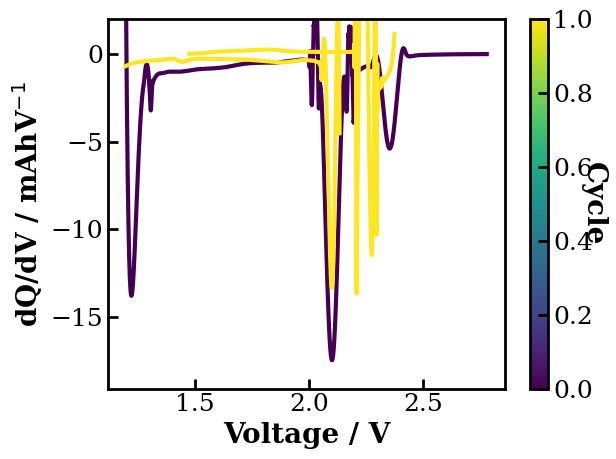

In [94]:
dir_name = os.path.join(id_to_path('CC064B'), 'outputs')
csv_files = glob.glob(os.path.join(dir_name,'*.csv'))
print(csv_files)
summary_file = os.path.join(dir_name,'cycle_summary.csv')
data_file = [file for file in csv_files if 'cycle_summary' not in file and 'PEIS' not in file][0]
df = pd.read_csv(data_file)
df_sum = pd.read_csv(summary_file)
df_no_ocv = df[df['state'] != 'R']
df_no_CV = df_no_ocv[df_no_ocv['Voltage'] < 2.99]

cycle_mask = df['half cycle'] == 1
dis_mask = df['state'] == '1'
rest_mask = df['state'] == 'R'
disch_overpotential = df[cycle_mask & rest_mask]['Voltage'].max() - df[cycle_mask & dis_mask]['Voltage'].min()
print(disch_overpotential)

ec.charge_discharge_plot(df, cycles=[0], norm='mass')
ec.multi_dqdv_plot(df_no_CV, cycles=[0,1], polynomial_spline=1)
plt.ylim(top=2)
# for x in [2.66, 2.90]:
#     plt.axvline(x, linestyle='--', linewidth=1)

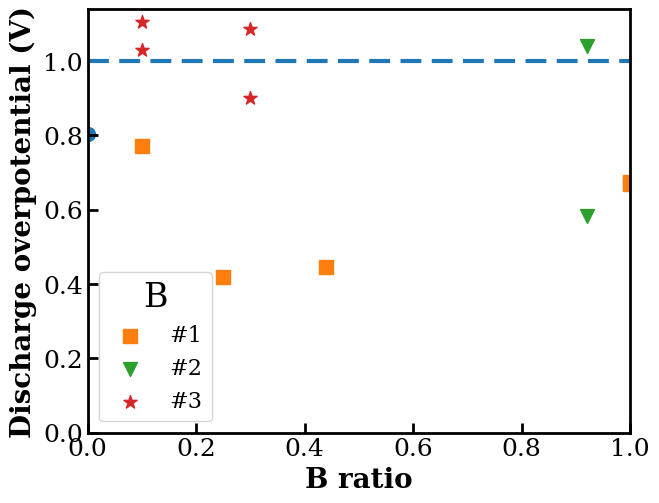

In [22]:
plt.subplots(figsize=(7,5.5))
plt.scatter([0], [0.804], label='_')
plt.scatter([0.1, 0.25, 0.44, 1, 1], [0.771, 0.418, 0.445, 0.673, 0.670], marker='s', label='#1')
plt.scatter([0.92, 0.92], [1.039, 0.584], marker='v', label='#2')
plt.scatter([0.1, 0.1, 0.3, 0.3], [1.030, 1.105, 1.087, 0.901], marker='*', label='#3')

plt.legend(title='B')
plt.xlim(0,1)
plt.ylim(bottom=0)
plt.xlabel('B ratio')
plt.ylabel('Discharge overpotential (V)')
plt.axhline(1, linestyle='--')